# Neural Network Eigenvalue Solver With Tensorflow

This notebook is an implementation of the algorithm presented in the paper [_Neural Networks Based Approach for Computing Eigenvectors and Eigenvalues of Symmetric Matrix_](https://www.sciencedirect.com/science/article/pii/S0898122104901101) by Zhang Yi and Yan Fu.

## Introduction

Below is an algorithm for a neural network that can be used to find the smallest or largest eigenvectors of a symmetric, positive definite matrix.

* Positive definite: z$^T$Az > 0 for ever nonzero column, z, of A
* Symmetric: A$^T$ = A

Eigenvectors, and the resulting eigenvalues, of matrices are not only used in mathematics, but are important in many science and engineering applications.  Particularly in physics it is important to know the eigenvectors and eigenvalues of matrices known as Hamiltonains, which describe a physical system.  The smallest eigenvalue of a Hamiltonian is the lowest energy of the system and the largest eigenvalue is the highest energy.  The eigenvectors that correspond to the smallest and largest eigenvalues represent the system in its lowest and highest energy states.  Typically in physics, the lowest and highest eigenvalues, and corresponding eigenvectors, are the most important.

## Neural Network Architecture

The neural network calculates an eigenvector of a given matrix using the following differential equation.  Let A be an nxn symmetric matrix, x(t) be the trial eigenvector (i.e. the output of the neural network), and I is the nxn identity matrix.

$\frac{dx(t)}{dt} = \dot{x}(t) = -x(t) + f(x(t))$

for t $\geq$ 0, where $f(x) = [x^TxA + (1-x^TAx)I]x$.  

When x(t), the output of the neural network, is fully converged (i.e. is no longer changing) then $\dot{x}(t) = 0$.  Then

$ 0 = -x(t) + f(x(t))$

$ x(t) = f(x(t))$

Therefore, the neural network is converged with its output (the trial eigenvector), x, is equal to the value of f(x).  The loss function of the neural network is defined to be MSE (x, f(x)), where MSE is the mean-squared error function.

$MSE(x, y) = \sum_i (x_i - y_i)^2$

In practice the beginning trial eigenvector, x(0), will have to be a vector of random numbers of the correct dimension.  However, it can be shown that any guess for the eigenvector will cause the neural network to converge to a true eigenvector of the matrix (See Theorem 3 of the above paper).

Once the neural network has determined the converged eigenvector, x(t $\rightarrow\infty$), the eigenvalue of the matrix corresponding to that eigenvector can be found using the below equation, which is known as the Rayleigh quotient.

$\lambda (t \rightarrow\infty) = \frac{x(t \rightarrow\infty)^TAx(t \rightarrow\infty)}{x(t \rightarrow\infty)^Tx(t \rightarrow\infty)}$

## A Deviation from the Paper's Algorithm

Though the author's of the paper suggest that there is a predetermined way to guarentee the algorithm searches for the smallest or largest eigenvalues, this is not found to work in practice.  Instead, to ensure that the smallest or the largest eigenvalues can always be found a change was made to the loss function, which will be described below.


## Code


Below is the code for implenting the above algorithm.

Note: this code is written using Tensorflow 1.  To run the code with Tensorflow 2 replace the `import tensorflow as tf` line with 

```
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
```

In [5]:
##############################
# IMPORTS
##############################
# Third-Party Imports
# For machine learning, making sure to import version 1 of Tensorflow, not 
# version 2
import tensorflow as tf
# For matrix manipulation and finding analytical eigenvalues
import numpy as np

A method for the function f(x), defined above.  This will be used later.

In [0]:
##############################
# F(X)
##############################
def f_x(x, A):
    """
        Inputs:
            x (a Tensorflow tensor): the trial eigenvector (i.e. the output
                of the neural network)
            A (a 2D Numpy array): the matrix to find eigenvectors of
        Returns:
            f (a Tensorflow tensor): the result of the function f(x(t)), 
                defined in the paper referenced above.  When x(t) is 
                converged, f(x(t)) = x(t)
        Returns the value of f(x) at a given value of x.
    """
    xTxA = (tf.tensordot(tf.transpose(x), x, axes=1)*A)
    # (1- xTAx)*I
    xTAxI = (1- tf.tensordot(tf.transpose(x), tf.tensordot(A, x, axes=1), axes=1))*np.eye(matrix_size)
    # (xTx*A - (1- xTAx)*I)*x
    f = tf.tensordot((xTxA + xTAxI), x, axes=1)

    return f

The code for the neural network.  The code is split into five sections:
1. Set-up.  The first section of code defines the identity matrix, I, and the initial trial eigenvector, x0.  These must then be converted to tensors in order to be used with Tensorflow.
2. Next the neural network is set up using the argument nn_structure, a list of numbers.  The length of the list indicates how many hidden layers are in the network design and each number in the list indicates the number of hidden neurons in that layer.  A final output layer is added to the end of the hidden layers, with its dimension being the size of the eigenvector.
3. The loss function is defined to be the mean squared error between x, the output of the neural network, and f(x), with an additional term added to control which eigenvector is found.  The argument eigen_guess controls which eigenvector is found.  A guess larger than the largest eigenvalue of the matrix will always result in the largest eigenvector being found a a guess smaller then the smallest eigenvalue will always result in the smallest eigenvector being found.  In practice when the approximate eigenvalues are not known, the guesses can be substituted with a very large number with a positive sign for the largest eigenvector and a negative sign for the smallest eigenvector.  The argument eigen_lr, controls how much this term contributes to the overall loss function.  Setting this term to zero means that the neural network will find any eigenvector of the given matrix.
4. Setting up the training portion of the neural network by defining the optimizer and instructing the neural network to minimize the loss fuction.
5. For each training iteration of the neural network the trial eigenvalue is calculated from the trial eigenvector.  The change of this eigenvalue from the last eigenvalue is calculaed to end the training process with sequential eigenvalues are sufficiently close.  For every hundreth training iteration the current state of the network is displayed to the console, if verbose is set to `True` in the arguments.  

In [0]:
##############################
# NN EIGENVALUE
##############################
def NN_Eigenvalue(matrix_size, A, max_iterations, nn_structure, eigen_guess, 
                    eigen_lr, delta_threshold, verbose):
    """
        Inputs:
            matrix_size (an int): the dimension of the matrix
            A (a 2D Numpy array): A square, symmetric matrix to find 
                an eigenvector and eigenvalue of.
            max_iterations (an int): the maximum number of training iterations 
                to be used by the neural network
            nn_structure (a list): the number of neurons in each layer of the
                neural network
            eigen_guess (an int): to find the lowest eigenvalue, a number smaller
                than the predicted eigenvalue.  To find the largest eigenvalue,
                a number larger than the predicted eigenvalue.
            eigen_lr (a float): the learning rate for the portion of the loss
                function that controls which eigenvalue is found.  Set to 0.0
                to find a random eigenvalue.
            delta_threshold (a float): the minimum value desired between two
                sequentially calculated eigenvalues
            verbose (a boolean): True case prints the state of the eigenvalue for
                every 100th training iteration.
        Returns:
            eigenvalue (a float): the predicted eigenvalue of matrix A
            eigenvector (a numpy array): the predicted eigenvector of the matrix 
                A
        Computes a prediction for an eigenvalue and an eigenvector of a given
        matrix using a neural network.  Parameters are given to control which
        eigenvalue and eigenvector are found.
    """
    # Defining the 6x6 identity matrix
    I = np.identity(matrix_size)
    
    # Create a vector of random numbers and then normalize it
    # This is the beginning trial solution eigenvector
    x0 = np.random.rand(matrix_size)
    x0 = x0/np.sqrt(np.sum(x0*x0))
    # Reshape the trial eigenvector into the format for Tensorflow
    x0 = np.reshape(x0, (1, matrix_size))

    # Convert the above matrix and vector into tensors that can be used by
    # Tensorflow
    I_tf = tf.convert_to_tensor(I)
    x0_tf = tf.convert_to_tensor(x0, dtype=tf.float64)

    # Set up the neural network with the specified architecture
    with tf.variable_scope('dnn'):
        num_hidden_layers = np.size(nn_structure)

        # x0 is the input to the neural network
        previous_layer = x0_tf
        # Hidden layers
        for l in range(num_hidden_layers):
            current_layer = tf.layers.dense(previous_layer, nn_structure[l],activation=tf.nn.relu )
            previous_layer = current_layer

        # Output layer
        dnn_output = tf.layers.dense(previous_layer, matrix_size)
      
    # Define the loss function
    with tf.name_scope('loss'):
        # trial eigenvector is the output of the neural network
        x_trial = tf.transpose(dnn_output) 
        # f(x)
        f_trial = tf.transpose(f_x(x_trial, A))
        # eigenvalue calculated using the trial eigenvector using the 
        # Rayleigh quotient formula
        eigenvalue_trial = tf.transpose(x_trial)@A@x_trial/(tf.transpose(x_trial)@x_trial)
        
        x_trial = tf.transpose(x_trial) 

        # Define the loss function
        loss = tf.losses.mean_squared_error(f_trial, x_trial) + \
                eigen_lr*tf.losses.mean_squared_error([[eigen_guess]], eigenvalue_trial)
                                                                                                        
    # Define the training algorithm and loss function
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer()
        training_op = optimizer.minimize(loss)

    ## Execute the Tensorflow session
    with tf.Session() as sess:  
        # Initialize the Tensorflow variables
        init = tf.global_variables_initializer()
        init.run()

        # Define for calculating the change between successively calculated
        # eigenvalues
        old_eig = 0

        for i in range(max_iterations):
            sess.run(training_op)
            # Compute the eigenvalue using the Rayleigh quotient
            eigenvalue = (x_trial.eval() @ (A @ x_trial.eval().T)
                        /(x_trial.eval() @ x_trial.eval().T))[0,0]
            eigenvector = x_trial.eval()

            # Calculate the change between the currently calculated eigenvalue
            # and the previous one
            delta = np.abs(eigenvalue-old_eig)
            old_eig = eigenvalue
            
            # Print useful information every 100 steps
            if verbose:
                if i % 100 == 0:
                    l = loss.eval()
                    print("Step:", i, "/",max_iterations, "loss: ", l,
                          "Eigenvalue:" , eigenvalue)
            # Kill the loop if the change in eigenvalues is less than the 
            # given threshold
            if delta < delta_threshold: 
                break

    # Return the converged eigenvalue and eigenvector
    return eigenvalue, eigenvector

## Test Matrices

The above neural network will work with any symmetric, positive definite matrix.  A matrix, A, can be made symmetric using the following formula, $A_{sym} = (A + A^T)/2$.  A symmetric matrix filled with random numbers can be created using the following code. 

In [0]:
def random_symmetric (matrix_size):
    """
        Inputs:
            matrix_size (an int): the size of the matrix to be constructed
        Returns:
            A (a 2D Numpy array): a symmetric matrix
        Constructs a symmetric matrix of the given size filled with random numbers.
    """

    # Create a matrix filled with random numbers
    A = np.random.rand (matrix_size, matrix_size)

    # Ensure that matrix A is symmetric
    A = (np.transpose(A) + A) / 2

    return A

Symmetric matrices can also occur with physical relevance.  The following sets up the Hamiltonian for the 4 particle 4 hole pairing model with no broken pairs.  More information on the pairing model can be found in Chapter 10 of  [this book](https://link.springer.com/book/10.1007/978-3-319-53336-0).

In [0]:
def pairing_model_4p4h (g, delta):
    """
        Inputs:
            g (a float): the interaction strength
            delta (a float): the spacing between energy levels
        Returns:
            A (a 2D Numpy array): the Hamiltoian for the 4 particle, 4 hole
                pairing model
        Calculates the Hamiltonian for the 4 particle 4 hole pairing model for
        the no broken pairs case.  For more information see Chapter 10 of
        LNP 936.
    """
    A = np.array(
        [[2*delta-g,    -0.5*g,     -0.5*g,     -0.5*g,    -0.5*g,          0.],
        [   -0.5*g, 4*delta-g,     -0.5*g,     -0.5*g,        0.,     -0.5*g ], 
        [   -0.5*g,    -0.5*g,  6*delta-g,         0.,    -0.5*g,     -0.5*g ], 
        [   -0.5*g,    -0.5*g,         0.,  6*delta-g,    -0.5*g,     -0.5*g ], 
        [   -0.5*g,        0.,     -0.5*g,     -0.5*g, 8*delta-g,     -0.5*g ], 
        [       0.,    -0.5*g,     -0.5*g,     -0.5*g,    -0.5*g, 10*delta-g ]])
    return A


## Test the Accuracy of the Neural Network

The below code uses the neural network to find the eigenvalue of a given matrix.  It then compares the neural network eigenvalue to the analytical eigenvalue calcualted with the Numpy library.

In [10]:
# Defining variables
matrix_size = 6 # Size of the matrix
max_iterations = 5000 # Maximum number of iterations
nn_structure = [100,100] # Number of hidden neurons in each layer
eigen_guess =  70 # Guess for the eigenvalue (see the header of NN_Eigenvalue)
eigen_lr = 0.01 # Eigenvalue learnign rate (see the header of NN_Eigenvalue)
delta_threshold = 1e-16 # Kill condition
verbose = True # True to display state of neural network evrey 100th iteration

# Create the matrix to be used
A = random_symmetric (matrix_size)
#A = pairing_model_4p4h (0.5, 1.0)

# Find the eigenvalues and the eigenvectors using Numpy to compare to the 
numpy_eigenvalues, numpy_eigenvectors = np.linalg.eig(A)

# Reset the Tensorflow graph, causes an error if this is not here
# Since the above cells are not re-ran every time this one is, they are not 
# reset.  This line is needed to reset the Tensorflow computational graph to
# avoid variable redefinition errors. 
tf.reset_default_graph()

# Calcualte the estimate of the eigenvalue and the eigenvector
eigenvalue, eigenvector = NN_Eigenvalue(matrix_size, A, max_iterations,
                                        nn_structure, eigen_guess, eigen_lr, 
                                        delta_threshold, verbose)

## Compare with the analytical solution
print("\n Numpy Eigenvalues: \n", numpy_eigenvalues)
print("\n Final Numerical Eigenvalue \n", eigenvalue)
diff = np.min(abs(numpy_eigenvalues - eigenvalue))
print("\n")
print('Absolute difference between Numerical Eigenvalue and TensorFlow DNN = ',diff)



Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Step: 0 / 5000 loss:  48.320076 Eigenvalue: 0.48735753924919706
Step: 100 / 5000 loss:  44.71716 Eigenvalue: 3.129111427296011
Step: 200 / 5000 loss:  44.717133 Eigenvalue: 3.129124544393247

 Numpy Eigenvalues: 
 [ 3.12912454 -0.80240881 -0.29930002  0.03618002  0.3708515   0.60005076]

 Final Numerical Eigenvalue 
 3.129124544563733


Absolute difference between Numerical Eigenvalue and TensorFlow DNN =  7.682743330406083e-14


## Test to See How Many Eigenvalues the Network Can Find

This test will run the program many times, without using an eigenvalue guess, to see if the network is capable of finding all of the eigenvalues, and in what distribution.  The neural network will be minimized quickest at whichever eigenvector of the matrix is closest to the initial trial eigenvector.  Since the initial trial eigenvector is initialized to a random vector, it may take several trials to find all of the eigenvalues, and even more to determine the probability distribution of finding them.

The below code is runs the  neural network a set number of times and keeps track of which eigenvalue is found.  It then plots the results.

Note that the neural network in this test converges significantly slower than the neural network in the above test due to the less constrained loss function.

Trial  0
Trial  1
Trial  2
Trial  3
Trial  4
Trial  5
Trial  6
Trial  7
Trial  8
Trial  9


([<matplotlib.axis.XTick at 0x7f5213364a90>,
 <a list of 5 Text xticklabel objects>)

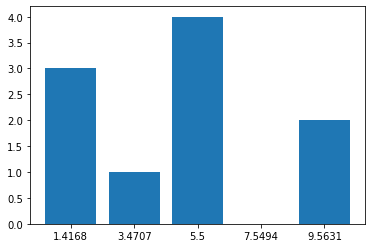

In [11]:
# Defining variables
matrix_size = 6 # Size of the matrix
max_iterations = 50000 # Maximum number of iterations
nn_structure = [100] # Number of hidden neurons in each layer
eigen_guess =  0.0 # No guess for the eigenvalue
eigen_lr = 0.0 # Set the eigenvalue learning rate to zero to find all eigenvalues
delta_threshold = 1e-16 # Kill condition
verbose = False # No need to display state of neural network

# Create the matrix to be used
#A = random_symmetric (matrix_size)
A = pairing_model_4p4h (0.5, 1.0)

# Find the eigenvalues and the eigenvectors using Numpy to compare to the 
numpy_eigenvalues, numpy_eigenvectors = np.linalg.eig(A)

# Create a dictionary where the keys are the analytical eigenvalues of the matrix
eigens_found_dic = {}
for eigenval in numpy_eigenvalues:
    # Round the keys to four decimal places to account for differences in the
    # analytical and neural network solutions.  This number can be changed as 
    # needed.
    eigens_found_dic[np.round(eigenval, decimals=4)] = 0

# Number of different times to run the neural network
trials = 10

for i in range (trials):
    print ('Trial ', i)
    # Reset the Tensorflow graph 
    tf.reset_default_graph()
    # Calcualte the estimate of the eigenvalue and the eigenvector
    eigenvalue, eigenvector = NN_Eigenvalue(matrix_size, A, max_iterations, nn_structure, eigen_guess, 
                        eigen_lr, delta_threshold, verbose)
    # Increment the correct entry in the dictionary
    eigens_found_dic[np.round(eigenvalue, decimals=4)] += 1

# Import matplotlib to make a graph
import matplotlib.pyplot as plt

# Plot the values stored in the dictionary then set the ticks on the x-axis
# equal to the dictionary keys
plt.bar(range(len(eigens_found_dic)), list(eigens_found_dic.values()), align='center')
plt.xticks(range(len(eigens_found_dic)), list(eigens_found_dic.keys()))